# Fundamentals: Solving the Poisson equation

Authors: Hans Petter Langtangen, Anders Logg \\
Adapted to FEniCS-X by Jørgen S. Dokken 

The goal of this tutorial is to solve one of the most basic PDEs, the Poisson equations, with a few lines of code in FEniCS-X. We start by introducing the most fundamental FEniCS objects, such as `Mesh`, `Function`, `FunctionSpace`, `TrialFunction` and `TestFunction`, and learn how to write a basic PDE solver. 
This will include:
- How to formulate a mathematical variational problem
- How to apply boundary con1ditions
- How to solve the discrete linear system
- How to visualize the solution

The Poisson equation is the following boundary-value problem

$ -\nabla^2 u(\mathbf{x}) = f(\mathbf{x}) \quad \mathbf{x} \in \Omega$

$ u(\mathbf{x}) = u_D(\mathbf{x})\quad \mathbf{x} \in \partial\Omega$

Here, $u=u(\mathbf{x})$ is the unknown function, $f=f(\mathbf{x})$ is a prescribed function, $\nabla^2$ the Laplace operator, often written as $\Delta$, $\Omega$ the spatial domain, and $\partial\Omega$ is the boundary of $\Omega$. The Poisson problem, including both the PDE $-\nabla^2 u = f$ and the boundary condition $u=u_D$ on $\partial\Omega$, is an example of a _boundary-value problem_, which must be precisely state before it makes sense to start solving it numerically with FEniCS-X. 

In the two dimensional space with coordinates $x$ and $y$, we can expand the Poisson equation as

$ -\frac{\partial^2 u}{\partial x^2} -
\frac{\partial^2 u}{\partial y^2} = f(x,y)$

The unknown $u$ is now a function of two variables, $u=u(x,y)$, defined over the two-dimensional domain $\Omega$. 

The Poisson equation arises in numerous physical contexts, including
heat conduction, electrostatics, diffusion of substances, twisting of
elastic rods, inviscid fluid flow, and water waves. Moreover, the
equation appears in numerical splitting strategies for more complicated
systems of PDEs, in particular the Navier--Stokes equations.

Solving a boundary value problem in FEniCS consists of the following steps:

1. Identify the computational domain $\Omega$, the PDE, and its corresponding boundary conditions and source terms $f$.
2. Reformulate the PDE as a finite element variational problem.
3. Write a Python program defining the computational domain, the boundary conditions, the variational problem and the source terms, using FEniCS.
4. Run the Python program to solve the boundary-value problem. Optionally, you can extend the program to derive quantities such as fluxes and averages,
and visualize the results.

As we have already covered step 1., we shall now cover step 2-4.

## Finite element variational formulation

FEniCS is based on the finite element method, which is a general and
efficient mathematical machinery for the numerical solution of
PDEs. The starting point for the finite element methods is a PDE
expressed in \emph{variational form}. For readers not familiar with variational problems, it is suggested to reading a proper book on the finite element method in addition, as this tutorial is meant as a brief introduction to the subject. See the [original tutorial]([The FEniCS tutorial](https://www.springer.com/gp/book/9783319524610)) (Chapter 1.6.2).

The basic recipe for turning a PDE into a variational problem is:
- Multiply the PDE by a function $v$
- Integrate the resulting equation over the domain $\Omega$
- Perform integration by parts of terms with second order derivatives. 

The function $v$ which multiplies the PDE is called a _test function_. The unknown function $u$ that is to be approximated is referred to as a _trial function_. 
The terms trial and test functions are used in FEniCS-X too. The test and trial functions belong to certain _function spaces_ that specify the properties of the functions.

In the present case, we multiply the equation by a test function $v$ and  integrate over $\Omega$:

$\int_\Omega -\nabla^2 u v \mathrm{d} x = \int_\Omega f v \mathrm{d} x$

Here $\mathrm{d} x$ denotes the differential element for integration over the domain $\Omega$. We will later let $\mathrm{d} s$ denote the differential element for integration over the boundary of $\Omega$. 

A rule of thumb is that when we derive variational formulations is that one tries to keep the order of derivatives of $u$ and $v$ as small as possible. 
Here, we have a second-order differential of $u$, which can be transformed to a first derivative by employing the technique of 
[integration by parts](https://en.wikipedia.org/wiki/Integration_by_parts).
The formula reads 

$ -\int_\Omega (\nabla^2 u)v \mathrm{d}x
= \int_\Omega\nabla u\cdot\nabla v \mathrm{d}x - \int_{\partial\Omega}\frac{\partial u}{\partial n}v \mathrm{d}s ,$

where $\frac{\partial u}{\partial n}=\nabla u \cdot n$ is the derivative of $u$ in the outward normal direction $n$ on the boundary.

Another feature of variational formulations is that the test function $v$ is required to vanish on the parts of the boundary where the solution $u$ is known. See for instance [Langtangen, Mardal 2019](t1.md/#Langtangen_Mardal_FEM_2019).

In the present problem, this means that $v$ is $0$ on the whole boundary $\partial\Omega$. In the present problem, it means that the second term in the integration by parts formula is zero, and we have that 

$\int_\Omega \nabla u \cdot \nabla v \mathrm{d} x = \int_\Omega f v\mathrm{d} x$

If we require that this equation holds for all test functions $v$ in some suitable space $\hat{V}$, the so-called _test space_, we obtain a well-defined mathematical problem that uniquely determines the solution $u$ which lies in some function space $V$. Note that $V$ does not have to be the same space as 
$\hat{V}$. We call the space $V$ the _trial space_. We refer to the equation above as the _weak form_/_variational form_ of the original boundary value problem. We now properly state our variational problem:
Find $u\in V$ such that 

$\int_\Omega \nabla u \cdot \nabla v \mathrm{d} x = \int_\Omega f v\mathrm{d} x\qquad \forall v \in \hat{V}.$

For the present problem, the test and trial spaces $V$ and $\hat{V}$ is defined  as

$ V=\{v\in H^1(\Omega) \vert v=u_D \quad \text{on } \partial \Omega \},$

$ \hat{V}=\{v\in H^1(\Omega) \vert v=0 \quad \text{on } \partial \Omega \}.$

In short, $H^1(\Omega)$ is the Sobolev space containing functions $v$ such that $v^2$ and $\vert \nabla v \vert ^2$ have finite integrals over $\Omega$. The solution of the underlying
PDE must line in a function space where the derivatives are 
also continuous, but the Sobolev space $H^1(\Omega)$ allows functions with discontinuous derivatives.
This weaker continuity requirement in our weak formulation (caused by the integration by parts) is of great importance when it comes to constructing the finite element function space. In particular, it allows the use of piecewise polynomial function spaces. This means that the function spaces are constructed 
by stitching together polynomial functions on simple domains 
such as intervals, triangles, quadrilaterals, tetrahedrons and
hexahedrons. 

The variational problem is a _continuous problem_: it defines the solution $u$ in the infinite-dimensional function space $V$.
The finite element method for the  Poisson equation finds an approximate solution of the variational problem by replacing the infinite-dimensional function spaces $V$ and $\hat V$ by _discrete_ (finite dimensional) trial and test spaces $V_h\subset V$ and $\hat{V}_h \subset \hat{V}$. The discrete
variational problem reads: Find $u_h\in V_h$ such that 

$\int_\Omega \nabla u_h \cdot \nabla v \mathrm{d} x = \int_\Omega fv \mathrm{d} x \quad \forall v \in \hat{V}_h.$

This variational problem, together with suitable definitions of $V_h$ and $\hat{V}_h$ uniquely define our approximate numerical solution of the Poisson equation. 
Note that the boundary condition is encoded as part of the test and trial spaces. This might seem complicated at first glance, 
but means that the finite element variational problem and the continuous variational problem looks the same. 

## Abstract finite element variational formulation

We will introduce the following notations for variational problems:
Find $u\in V$ such that 

$ a(u,v)=L(v)\qquad \forall v \in \hat{V}.$

For the Poisson equation, we have:

$ a(u,v)= \int_{\Omega} \nabla u \cdot \nabla v \mathrm{d} x,$

$ L(v)= \int_{\Omega} fv \mathrm{d} x.$

From literature $a(u,v)$ is known as the _bilinear form_ and $L(V)$ as a _linear form_. 
For every linear problem, we will identify all terms with the unknown $u$ and collect them in $a(u,v)$, and collect all terms with only  known functions in $L(v)$.

To solve a linear PDE in FEniCS-X, such as the Poisson equation, a user thus needs to perform two steps:

1. Choose the finite element spaces $V$ and $\hat{V}$ by specifying the domain (the mesh) and the type of function space (polynomial degree and type).
2. Express the PDE as a (discrete) variational problem: Find $u\in V$ such that $a(u,v)=L(v)$ for all $v \in \hat{V}$.

## Choosing a test problem
The Poisson problem has so far featured general domain $\Omega$ and general functions $u_D$ for the boundary conditions and $f$ for the right hand side.
Therefore, we need to make specific choices of $\Omega, u_D$ and $f$. A wise choice is to construct a problem  with a known analytical solution, so that we can check that the computed solution is correct. The primary candidates are lower-order polynomials. The continuous Galerkin finite element spaces of degree $r$ will exactly reproduce polynomials of degree $r$. 
<!-- Particularly, piecewise linear continuous Galerkin finite elements are able to exactly reproduce a quadratic polynomial on 
a uniformly partitioned mesh. -->
 We use this fact to construct a quadratic function in $2D$. In particular we choose
$ u_e(x,y)=1+x^2+2y^2.$

Inserting $u_e$ in the original boundary problem, we find that  
$f(x,y)= -6,\qquad u_d(x,y)=u_e(x,y)=1+x^2+2y^2,$
regardless of the shape of the domain as long as we prescribe 
$u_e$ on the boundary.

For simplicity, we choose the domain to be a unit square

$\Omega=[0,1]\times [0,1] $

This simple but very powerful method for constructing test problems is called _the method of manufactured solutions_. 
First pick a simple expression for the exact solution, plug into
the equation to obtain the right-hand side (source term $f$). Then solve the equation with this right hand side, and using the exact solution as boundary condition. Finally, we create a program that tries to reproduce the exact solution.

Note that in many cases, it can be hard to determine if the program works if it produces an error of size $10^{-5}$ on a
$20 \times 20$ grid. However, since we are using Sobolev spaces,
we usually known about the numerical errors _asymptotic properties_. For instance that it is proportional to $h^2$ if $h$ is the size of a cell in the mesh. We can then compare the error on meshes with different $h$-values to see if the asymptotic behavior is correct. This technique will be explained in detail in a later chapter *FIXME: add correct reference*.

However, in cases where we have a solution we know that should have no approximation error, we know that the solution should
be produces to machine precision by the program.

The first eight lines of the program is importing the different modules required for solving the problem.

In [1]:
import dolfinx
import dolfinx.cpp
import dolfinx.mesh
import dolfinx.plotting
import matplotlib.pyplot
import numpy
import ufl
from mpi4py import MPI
from petsc4py import PETSc

Not as opposed to a traditional FEniCS code, FEniCS-X is more modular. Instead of wrapping [MPI](https://mpi4py.readthedocs.io/en/stable/) and [PETSc](https://pypi.org/project/petsc4py/) modules inside dolfin-X, we would like to directly use the modules, as they are  well documented and makes dolfin-X easier
to understand.

## Generating  simple meshes
The next step is to define the discrete domain, _the mesh_

In [2]:
mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, 8, 8, dolfinx.cpp.mesh.CellType.triangle)

which defines a uniform finite element mesh over the unit square $\[0,1]\times\[0, 1]$. The mesh consists of _cells_, which in 2D can be either triangles of quadrilaterals. Note that in addition to give how many elements we would like to have in each direction. We start by dividing the domain into $8\times 8$ quadrilaterals, which are subdivided into two triangles if
we will use triangular cells.
Note that we also supply the _MPI-communicator_. 
This is to specify how we would like the program to behave in parallel. If we supply `MPI.COMM_WORLD` we create a single mesh,
which data is distributed over the number of processors we 
would like to use. We can for instance run the program in 
parallel on two processors by using `mpirun`, as:
``` bash
 mpirun -n 2 python3 t1.py
```
However, if we would like to create a separate mesh on each processor, we can use `MPI.COMM_SELF`. This is for instance 
useful if we run a small problem, and would like to run it with
multiple parameters.

## Defining the finite element function space
 Once the mesh has been created, we can create the finite element function space $V$:

In [3]:
V = dolfinx.FunctionSpace(mesh, ("CG", 1))

The second argument is the tuple containing the type of finite element, and the element degree. The type of element here is "CG", which implies the standard Lagrange family of elements. 
Dolfin-X supports a large variety on elements on simplices 
(triangles and tetrahedrons) and non-simplices (quadrilaterals
and hexahedrons). For an overview, see:
*FIXME: Add link to all the elements we support*

The element degree in the code is 1. This means that we are choosing the standard $P_1$ linear Lagrange element, which has degrees of freedom at the vertices. The computed solution will be continuous across elements and linearly varying in $x$ and $y$ inside each element. Higher degree polynomial approximations is obtained by increasing the degree argument. 

## Defining the boundary conditions

The next step is to specify the boundary condition $u=u_D$ on $\partial\Omega_D$, which is done by

In [4]:
uD = dolfinx.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)
uD.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim, lambda x: numpy.full(x.shape[1], True, dtype=numpy.bool))
bc = dolfinx.DirichletBC(uD, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

As we observe here, this is done  over several steps. The first step is to define the function that will contain the boundary information, `uD`. The next step is to interpolate the spatially
varying function into the function space. We use the [lambda-function](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) in Python to compactly define the 
spatially varying function. As we in our example distribute 
the the mesh the number of processors used, we need to 
update data on boundaries between processors. We do 
this by updating the underlying PETSc function.
We now have the boundary data (and in this case the solution of 
the finite element problem) represented in the discrete function space. Next we would like to apply the boundary values to all degrees of freedom that is on the boundary of the discrete domain. We start by identifying the facets (line-segments)
representing the outer boundary, using `locate_entities_boundary`. As one in most cases, as shown in later tutorials, only want to mark subsets of the outer boundary, we need to supply a function using a geometrical criteria for which facets should be marked. In this case, as we want to mark the whole boundary, we create a lambda-function that returns `True` for all facets on the boundary. 
Now that we have located the boundary facets, we locate the
dofs contained on these facets, using `locate_dofs_topological` and create the Dirichlet boundary condition.


## Defining the trial and test function

In mathematics, we distinguish between trial and test spaces $V$ and $\hat{V}$. The only difference in the present problem is the boundary conditions. In FEniCS-X, we do not specify boundary conditions as part of the function space, so it is sufficient to use a common space for the trial and test function:

In [5]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

## Defining the source term
As the source term is constant over the domain, we can efficiently represent is as constant:

In [6]:
f = dolfinx.Constant(mesh, -6)

This will speed of compilation of high performance 
C code for creating the linear system, as opposed to
`f = -6`.
## Defining the variational problem
We now have all the ingredients to define the variational problem

In [7]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

Note that there is a very close correspondence between the Python syntax and the mathematical syntax
$\nabla u \cdot \nabla v \mathrm{d} x$ and $fv\mathrm{d} x$. 
This is the key strength of FEniCS-X: the formulas in the variational formulation translate directly to very similar Python code, a feature that makes it easy to specify and solve complicated PDE problems. The language used to express weak forms in [UFL](t1.md/#ufl) (Unified Form Language).

## Expressing inner products
The inner product $\int_\Omega \nabla u \cdot \nabla v \mathrm{d} x$ can be expressed in various ways in UFL. We have used the notation `ufl.dot(ufl.grad(u), ufl.grad(v))*uf.dx`. The dot product in UFL computes the sum (contraction) over the last index of the first factor and first index of the second factor. In this case, both factors are tensors of rank one (vectors) and so the sum is just over the single index of both $\nabla u$ and $\nabla v$. To compute an inner product of matrices (with two indices), one must instead of `ufl.dot` use the function `ufl.inner`. For vectors, `ufl.dot` and `ufl.inner` are equivalent.

## Forming and solving the linear system

Having defined the finite element variational problem and boundary condition, we can use dolfin-X to compute the solution:

In [8]:
uh = dolfinx.Function(V)
dolfinx.solve(a == L, uh, bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

Here we have defined our approximate function `uh`, which will store the solution. The `solve`-command takes in the variational equality, the discrete function, the boundary condition and options to the backend linear algebra solver PETSc. In this case, we would like to solve the problem with a direct solver. See the [PETSc-documentation](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/PC/PCLU.html) of the method for more information.

Then, as after interpolation, we update shared indices not owned by the processor.

## Plotting the solution using the built-in plotting
Once the solution has been computed, we visualize it with the plot command

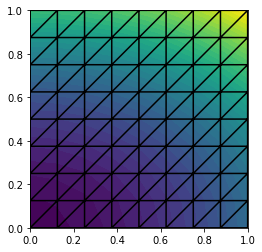

In [9]:
# Plot solution
dolfinx.plotting.plot(uh)
dolfinx.plotting.plot(mesh, color="k")
matplotlib.pyplot.savefig("uh.png")

We start by plotting the solution of the function, and overlays it with the mesh. Finally, we save the plot with matplotlib. 
One can also visualize this plot in an non-interactive mode, using `matplotlib.pyplot.show()`.

For more advanced post-processing, it is suggested to save the solution to file using either `dolfinx.io.VTKFile` or `dolfinx.io.XDMFFile` and using [Paraview](https://www.paraview.org/). This ifs especially suggested for 3D visualization.

In [10]:
import dolfinx.io
outfile = dolfinx.io.VTKFile("output.pvd")
outfile.write(uh)
xdmffile = dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output.xdmf", "w")
xdmffile.write_mesh(mesh)
xdmffile.write_function(uh)
xdmffile.close()

## Computing the error

Finally, we compute the error to check the accuracy of the solution. We do this by comparing the finite element solution `u` with the exact solution. We do this by interpolating the exact solution into the the $P_2$-function space.

In [11]:
# Compute exact solution
V2 = dolfinx.FunctionSpace(mesh, ("CG", 2))
uex = dolfinx.Function(V2)
uex.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)
uex.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

We compute the error in two different ways. First, we compute the $L^2$-norm of the error, defined by $E=\sqrt{\int_\Omega (u_D-u_h)^2\mathrm{d} x}$. We use UFL to express the $L^2$-error:

In [12]:
error_L2 = numpy.sqrt(dolfinx.fem.assemble_scalar(ufl.inner(uh - uex, uh - uex) * ufl.dx))

We also compute the maximum error at any degree of freedom.
As the finite element function $u$ can be expressed as a linear combination of basis functions $\phi_j$, spanning the space $V$:

$ u = \sum_{j=1}^N U_j\phi_j.$
By writing `solve(...)`
we compute all the coefficients $U_1,\dots, U_N$. These values are known as the _degrees of freedom_ (dofs). We can access the degrees of freedom by accessing the underlying vector in `uh`.
However, as a second order function space has more dofs than a linear function space, we cannot compare these arrays directly.
Therefore we compute the values of both `uex` and `uD` at the mesh nodes (for a linear mesh this is the vertices).

In [13]:
u_vertex_values = uh.compute_point_values()
u_ex_vertex_values = uex.compute_point_values()
error_max = numpy.max(numpy.abs(u_vertex_values - u_ex_vertex_values))
print("Error_L2 = {0:.2e}".format(error_L2))
print("Error_max = {0:.2e}".format(error_max))

Error_L2 = 8.24e-03
Error_max = 2.22e-15


# References
{% include _paper.html id="Langtangen_Mardal_FEM_2019" author = "Hans Petter Langtangen and Kent-Andre Mardal" doi = "10.1007/978-3-030-23788-2"  journal =" Springer International Publishing"  title = "Introduction to Numerical Methods for Variational Problems" year = "2019" %}
{% include _paper.html id="ufl" author="Martin S. Alnæs, Anders Logg, Kristian B. Ølgaard, Marie E. Rognes, and Garth N. Wells" doi="10.1145/2566630" journal="ACM Trans. Math. Softw."
title="Unified form language: A domain-specific language for weak formulations of partial differential equations" year="2014" volume="40" issue="2" %}